In [5]:
import numpy as np
import xarray as xr
from pivpy import io, pivpy

def vortex(
    n: int=128,
    r0: float=10.,
    vorticity: float=1.,
    mode: str='burgers',
    diver: float=None
)->xr.Dataset:
    """ Rankine or Burgers vortex synthetic field """


    if diver is None:
        diver = vorticity

    mid=n/2-1
    omega = vorticity/(2*1000) # angular velocity, in m/s/mm
    gamma = diver/(2*1000) # divergence, in m/s/mm

    vx = np.zeros((n,n))
    vy = np.zeros((n,n))

    for i in range(n):
        for j in range(n):
            radius = np.sqrt((i-mid)**2 + (j-mid)**2)
            if mode == 'rankine':
                if radius <= r0:
                    vx[i,j] = omega*(j-mid)
                    vy[i,j] = -omega*(i-mid)
                else:
                    vx[i,j] = omega*r0**2*(j-mid)/radius**2
                    vy[i,j] = -omega*r0**2*(j-mid)/radius**2
                
            elif mode == 'burgers':
                if radius != 0:    
                    vx[i,j] = omega*r0**2*(j-mid)/radius**2*(1-np.exp(-(radius/r0)**2))
                    vy[i,j] = -omega*r0**2*(i-mid)/radius**2*(1-np.exp(-(radius/r0)**2))
                    
                    if gamma:
                        vx[i,j] = vx[i,j] + gamma*r0**2*(i-mid)/radius**2*(1-np.exp(-(radius/r0)**2))
                        vy[i,j] = vy[i,j] + gamma*r0**2*(j-mid)/radius**2*(1-np.exp(-(radius/r0)**2))


    # new v1.20 : add a small constant value to avoid strictly 0 components
    vx = vx + np.max(np.abs(vx.flatten()))*1e-10
    vy = vy + np.max(np.abs(vy.flatten()))*1e-10

    dims = ('x','y','t')
    coords = dict([('x',range(n)),('y',range(n)),('t',[0])])

    vx = xr.DataArray(vx[:,:,np.newaxis], dims=dims, coords=coords)
    vy = xr.DataArray(vy[:,:,np.newaxis], dims=dims, coords=coords)

    dataset = xr.Dataset({"u": vx, "v": vy})
    dataset = io.set_default_attrs(dataset)

    return dataset

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot:title={'center':'t = 0 [frame]'}, xlabel='x (pix)', ylabel='y (pix)'>)

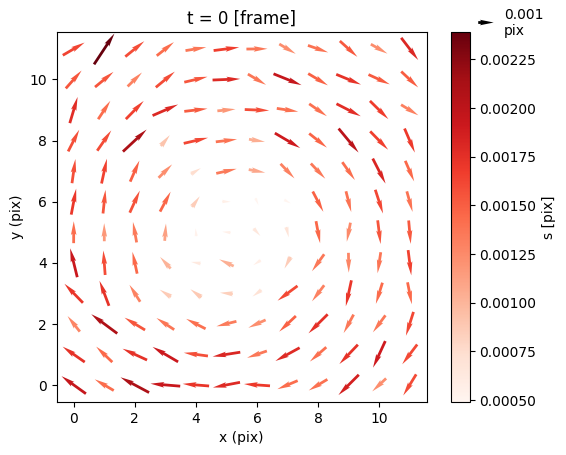

In [6]:
from pivpy import graphics
tmp = vortex(12,vorticity=1.,mode='burgers',r0=5,diver=0.1)
tmp["u"] += 0.00025*np.random.randn(12,12,1)
tmp["v"] += 0.00025*np.random.randn(12,12,1)
graphics.quiver(tmp, arrScale=10,colorbar=True,cmap='Reds',width=.0075)

In [7]:
# from https://github.com/kaipak/xrsigproc

from scipy.ndimage import gaussian_filter
def _get_dims(data):
    """Get primary x-y dimensions of dataset
    """
    return ('y', 'x')

def gaussian_smooth(data, sigma = [1., 1.], mask=False, mode='reflect'):
    """Apply gaussian kernel to convolution. Uses Scipy
       gaussian_filter method.
       Parameters:
       mode (str): {‘reflect’, ‘constant’, ‘nearest’, ‘mirror’, ‘wrap’}
                   What to do at edges of matrix input. See Scipy docs
                   for details on what these do.
    """
    dims = _get_dims(data)

    sc_gaussian_nd = lambda data: gaussian_filter(data, sigma, mode=mode)

    if mask:
        data_masked = data.where(data[mask_vars[dims]])
    else:
        data_masked = data.fillna(0.)

    return xr.apply_ufunc(sc_gaussian_nd, data_masked,
                          vectorize=True,
                          dask='parallelized',
                          input_core_dims = [dims],
                          output_core_dims = [dims],
                          # output_dtypes=[data.dtype]
                        )

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot:title={'center':'t = 0 [frame]'}, xlabel='x (pix)', ylabel='y (pix)'>)

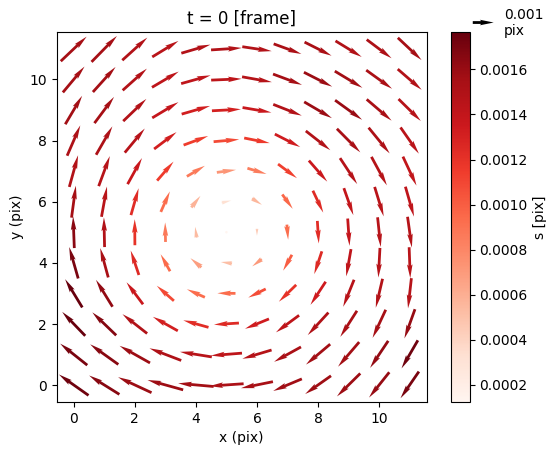

In [8]:
tmp = gaussian_smooth(tmp)
graphics.quiver(tmp, arrScale=10,colorbar=True,cmap='Reds',width=.0075)